### 0. Background: What are the main problems of REINFORCE?

In previous notebook, the [original reinforce](../vanilla-reinforce/reinforce_with_discrete_actions.ipynb) algorithm have issues:

#### Issue 1: noisy gradient and inefficient update process

In Mathematically, the gradient is given by an average over all the possible trajectories, 

$$
\nabla_\theta U(\theta) \approx \hat{g} = \frac{1}{m} \sum_{i=1}^m \sum_{t=0}^H \nabla_\theta \log \pi_\theta(a_t^{(i)} \mid s_t^{(i)}) R(\tau^{(i)})
$$

Since for each policy we have millions of trajectories for simple problems, and infinite for continuous problems, So,for practical purposes, we simply take one trajectory to compute the gradient, and update our policy. So a lot of times, the result of a sampled trajectory comes down to chance, and doesn't contain that much information about our policy.

#### Improvement 1: **Parallel Collect Multiple Trajectories**

For both above issues, the easiest option to reduce the noise in the gradient is to simply sample more trajectories! Using distributed computing, we can **collect multiple trajectories in parallel**, so that it won’t take too much time. Then we can estimate the policy gradient by averaging across all the different trajectories


#### Improvement 2: **Rewards Normalization**
  
There is another bonus for running multiple trajectories: we can collect all the total rewards and get a sense of how they are distributed. In many cases, the distribution of rewards shifts as learning happens. Reward = 1 might be really good in the beginning, but really bad after 1000 training episode. Learning can be improved if we normalize the rewards, where $μ$ is the mean, and $σ$ the standard deviation.

$$
R_i \leftarrow \frac{R_i - \mu}{\sigma}, \quad \mu = \frac{1}{N} \sum_{i=1}^N R_i, \quad \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (R_i - \mu)^2}
$$

(when all the $R_i$ are the same, $σ=0$, we can set all the normalized rewards to 0 to avoid numerical problems)

Intuitively, normalizing the rewards roughly corresponds to picking half the actions to encourage/discourage, while also making sure the steps for gradient ascents are not too large/small.


#### Issue 2: no clear credit assignment

A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.

The total reward **R** is the sum of rewards at each step:

$$
R = r_1 + r_2 + \dots + r_{t-1} + r_t + \dots
$$

The gradient estimate can be expressed as:

$$
g = \sum_t \left( \dots + r_{t-1} + r_t + \dots \right) \nabla_\theta \log \pi_\theta(a_t \mid s_t)
$$

At time-step **t**, before an action is decided, the agent has already received all the rewards up until step **t-1**. This part of the total reward is referred to as the **past reward**. The remaining part is denoted as the **future reward**:

$$
R_t^{past} = \dots + r_{t-1}, \quad R_t^{future} = r_t + \dots
$$

Thus, the total reward can be written as:

$$
R = R_t^{past} + R_t^{future}
$$

#### Improvement 3: only consider the future reward
Since the process is Markov, the action at time-step **t** can only affect the **future reward**, not the **past reward**. Therefore, the past reward should not contribute to the policy gradient. To properly assign credit to the action **a_t**, we only consider the future reward.

The updated policy gradient becomes:

$$
g = \sum_t R_t^{future} \nabla_\theta \log \pi_\theta(a_t \mid s_t)
$$


> Why is it okay to modify the gradient?
> - Ignoring past rewards changes the gradient for each specific trajectory, but it does not change the **averaged gradient**. On average, we are still maximizing the expected reward.
> - By using only the future reward, the resultant gradient is less noisy. This leads to faster and more stable training.




### 1. Import the Necessary Packages

In this notebook, we will implement and train a policy to play [atari-pong](https://ale.farama.org/environments/pong/), using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy.


In [1]:
import numpy as np
from enum import Enum
import ale_py
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from parallel_env import ParallelEnv
from plot_utils import display_frame, save_animation, plot_scores


%matplotlib inline
gym.register_envs(ale_py)

device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print("using device: ",device)

using device:  mps


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/pong.gif" alt="Mountain Car Environment" width="10%">
</div>

#### Continuous State Space
- **Observation Type**: `"rgb"`
- **Observation Space**: `Box(0, 255, (210, 160, 3), np.uint8)`
  - Observations are RGB images with dimensions 210x160 and 3 color channels. The pixel values range from 0 to 255.

#### Discrete Action Space
- **Type**: `Discrete(6)`
- **Actions**:
  - `0`: `NOOP` (No operation)
  - `1`: `FIRE`
  - `2`: `RIGHT`
  - `3`: `LEFT`
  - `4`: `RIGHTFIRE`
  - `5`: `LEFTFIRE`

> To simplify training, we will only use the following two actions:
> - `4`: `RIGHTFIRE`
> - `5`: `LEFTFIRE`

The `FIRE` part ensures the game starts again after losing a life.

#### Other Settings
1. **Frameskip**
    - **Value**: `4`
    - **Explanation**: The environment executes the same action for 4 consecutive frames before observing the next state. This deterministic frameskip makes the environment faster to train compared to the vanilla `Pong-v4`, which uses a stochastic frameskip of `(2, 5)`.

2. **Repeat Action Probability**
    - **Value**: `0.0`
    - **Explanation**: This setting ensures no randomness in action repetition. The same action will always have the same effect, making the environment fully deterministic and predictable.

By using deterministic frameskip and disabling action stickiness, `PongDeterministic-v4` is more efficient for training reinforcement learning models.


In [2]:
env = gym.make('PongDeterministic-v4')

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [3]:
# Explore state (observation) space
print("State space:\n", env.observation_space)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("Shape of State space 2 samples:")
print([env.observation_space.sample().shape for _ in range(2)])

# Generate some samples from the action space
print("Action space 2 samples:")
print(np.array([env.action_space.sample() for i in range(2)]))

State space:
 Box(0, 255, (210, 160, 3), uint8)
Action space:
 Discrete(6)
--------------------------------------------------
Shape of State space 2 samples:
[(210, 160, 3), (210, 160, 3)]
Action space 2 samples:
[4 4]


In [4]:
class Action(Enum):
    NOOP = 0         # No operation
    FIRE = 1         # Fire
    RIGHT = 2        # Move right
    LEFT = 3         # Move left
    RIGHTFIRE = 4    # Move right and fire
    LEFTFIRE = 5     # Move left and fire

### 3. Preprocessing

To speed up training, we can simplify the input by cropping the images and use every other pixel

<div style="text-align: center;">
    <img src="./images/preprocess.png" alt="Mountain Car Environment" width="50%">
</div>


In [5]:
def preprocess(image, bkg_color=np.array([144, 72, 17])):
    """
    Preprocess a single game frame by cropping, downsampling, and normalizing.

    Args:
        image (np.ndarray): The input image (game frame) as a NumPy array.
        bkg_color (np.ndarray): The RGB background color to subtract.

    Returns:
        np.ndarray: The processed image, normalized to [0, 1].
    """
    # Crop the image to remove irrelevant parts (e.g., score and borders)
    cropped_image = image[34:-16, :]
    # Downsample the image by taking every second pixel (both rows and columns)
    downsampled_image = cropped_image[::2, ::2]
    # Subtract the background color
    adjusted_image = downsampled_image - bkg_color
    # Convert to grayscale by taking the mean across the color channels
    grayscale_image = np.mean(adjusted_image, axis=-1)
    # Normalize pixel values to the range [0, 1]
    normalized_image = grayscale_image / 255.0

    return normalized_image


def preprocess_batch(images, bkg_color=np.array([144, 72, 17])):
    """
    Convert outputs of ParallelEnv to inputs for tensor processing.

    Args:
        images (list or np.ndarray): Batch of input images (game frames).
        bkg_color (np.ndarray): The RGB background color to subtract.
        device (str): The device to which the tensor will be moved (e.g., "cpu" or "cuda").

    Returns:
        torch.Tensor: The processed batch of images as a tensor, normalized to [0, 1].
    """
    # Ensure images are in a NumPy array
    # shape: (time_steps, height, width, channel)
    batch_images = np.asarray(images)

    # If the input has less than 5 dimensions, expand the dimensions
    # shape: (time_steps, batch, height, width, channels)
    if len(batch_images.shape) < 5:
        batch_images = np.expand_dims(batch_images, 1)

    # Process each image in the batch using logic from the preprocess function
    # shape: (time_steps, batch, height, width, channels)
    cropped_images = batch_images[:, :, 34:-16, :, :]  # Crop the images
    downsampled_images = cropped_images[:, :, ::2, ::2, :]  # Downsample the images
    adjusted_images = downsampled_images - bkg_color  # Subtract the background color
    
    # Convert to grayscale and normalize pixel values to [0, 1]
    # shape: (time_steps, batch, height, width)
    grayscale_images = np.mean(adjusted_images, axis=-1)  
    normalized_images = grayscale_images / 255.0

    # Rearrange the batch dimension to match the expected input format
    # shape: (batch, time_steps, height, width) or in other way
    #        (batch, channel, height, width)
    batch_input = torch.from_numpy(normalized_images).float()
    batch_input = batch_input.permute(1, 0, 2, 3)
    return batch_input


Original Frame Shape: (210, 160, 3)
Processed Frame Shape: (80, 80)


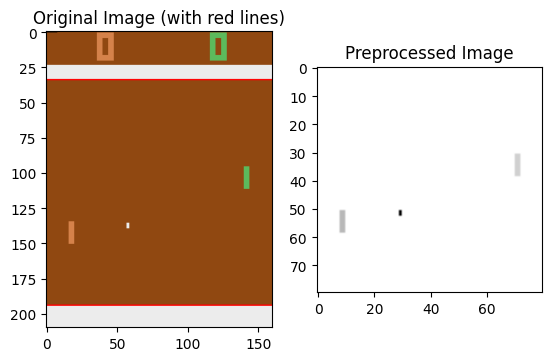

In [6]:
# Test: get 20-th frame
env.reset()
for _ in range(20):
    action = 1 # fire
    frame, *_ = env.step(action)

processed_frame = preprocess(frame)

display_frame(frame, processed_frame)

### 4. Define Policy

Here, we define our policy. Similar to [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), we modify the architechture of network for this problem.

- Action Value Network in DQN

<div style="text-align: center;">
    <img src="./images/dqn-network.png" alt="Mountain Car Environment" width="50%">
</div>

- Policy Network in Reinforce
  - input is the stack of two different frames (which captures the movement)
  - output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

<div style="text-align: center;">
    <img src="./images/policy-network.png" alt="Mountain Car Environment" width="60%">
</div>


In [23]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        self.RIGHTFIRE = Action.RIGHTFIRE.value
        self.LEFTFIRE = Action.LEFTFIRE.value
        
        # 80x80x2 input
        # Conv layers with progressively decreasing spatial dimensions
        # outputsize = (inputsize - kernel_size + stride) / stride
        # (round up if not an integer)

        # First convolutional layer: input 80x80x2 -> output 20x20x32
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4, stride=4)
        
        # Second convolutional layer: input 20x20x32 -> output 9x9x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)

        # Third convolutional layer: input 9x9x64 -> output 7x7x64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Flatten the output of the conv layers
        self.size = 7 * 7 * 64  # Flattened size after conv layers
        
        # Fully connected layers: progressively decreasing sizes
        self.fc1 = nn.Linear(self.size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 1)           # Final fully connected layer (output)
        
        
    def forward(self, x):
        # Pass through the convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor
        x = x.view(-1, self.size)
        
        # Pass through the fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        
        # the output is the probability of moving right, P(right)
        # so, for moving left, have P(left) = 1-P(right)
        return x

    @torch.no_grad()
    def select_action(self, frames, mode='inference'):
        """
        Select actions based on policy for either inference or trajectory collection.
        
        Args:
            frames: Tuple of (frame1, frame2) or preprocessed tensor
            mode: Either 'inference' for single action or 'collect' for trajectory collection
            
        Returns:
            For mode='inference': single action value
            For mode='collect': tuple of (states, actions, action_probs)
        """
        # Ensure frames are on the correct device
        if isinstance(frames, tuple):
            states = preprocess_batch(frames).to(next(self.parameters()).device)
        else:
            states = frames.to(next(self.parameters()).device)
        
        # Get action probabilities
        probs = self(states).squeeze().detach().cpu().numpy()
        
        if mode == 'inference':
            # Single instance inference
            action = self.RIGHTFIRE if np.random.random() < probs else self.LEFTFIRE
            return action
        
        elif mode == 'collect':
            # Batch processing for trajectory collection
            n = probs.shape[0]
            
            # Generate random values for all instances
            random_values = np.random.rand(n)
            
            # Select actions based on probabilities
            actions = np.where(
                random_values < probs,
                self.RIGHTFIRE,
                self.LEFTFIRE
            )
            
            # Calculate action probabilities
            action_probs = np.where(
                actions == self.RIGHTFIRE,
                probs,
                1.0 - probs
            )
            
            return states, actions, action_probs
        
        else:
            raise ValueError(f"Unknown mode: {mode}. Use 'inference' or 'collect'")

    def get_action_probs(self, states, actions):
        """
        Get probabilities for given states and actions.
        Useful for calculating policy gradients.
        
        Args:
            states: Preprocessed state tensor
            actions: Tensor of actions taken
            
        Returns:
            Tensor of action probabilities
        """
        probs = self(states).squeeze()
        probs = probs.view(*actions.shape)
        action_probs = torch.where(
            actions == self.RIGHTFIRE,
            probs,
            1.0 - probs
        )
        return action_probs
        

policy = Policy().to(device)
policy

Policy(
  (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [24]:
# we use the adam optimizer with learning rate 1e-4
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

### 5. Game Visualization
Visualize the interaction process of the environment and the policy.

<div style="text-align: center;">
    <img src="./images/interact.png" alt="Mountain Car Environment" width="60%">
</div>

In [9]:
# Random action function using numpy broadcasting
def get_random_action(n):
    return np.random.choice(
        [Action.RIGHTFIRE.value, Action.LEFTFIRE.value],
        size=n
    )

print(f"Sample action on inference: {get_random_action(1).item()}")
print(f"Sample action on collect: {get_random_action(4)}")

Sample action on inference: 4
Sample action on collect: [5 4 5 4]


In [10]:
def perform_random_steps(env, nrand, parallel=False):
    """
    Perform a number of random steps in the environment to initialize the game.
    Supports both single and parallel environments.
    
    Args:
        env: The game environment (single or parallel)
        nrand (int): Number of random steps to perform
        parallel (bool): Whether the environment is parallel
        
    Returns:
        tuple: The last two frames after performing random steps
    """
    # Reset environment
    env.reset()

    # Get environment size (1 for single env, n for parallel envs)
    n = len(env.ps) if parallel else 1
    
    # Unified action definitions
    fire_action = np.full(n, Action.FIRE.value, dtype=np.int32)
    noop_action = np.full(n, Action.NOOP.value, dtype=np.int32)
    
    # Start the game with a FIRE action
    env.step(fire_action.item() if n == 1 else fire_action)
    
    # Initialize frames
    frames1, frames2 = None, None

    # Perform random steps
    for _ in range(nrand):
        # Get and format random action
        action = get_random_action(n)
        frames1, _, dones, *_ = env.step(action.item() if n == 1 else action)
        frames2, _, dones, *_ = env.step(noop_action.item() if n == 1 else noop_action)
        
        # Check termination condition
        if (dones if n == 1 else dones.any()):
            break
    
    return frames1, frames2

In [11]:
def interact(env, policy, max_t=2000, preprocess=None, nrand=5):
    """
    Play a game using the given policy and display the animation.

    Args:
        env: The game environment.
        policy: The policy function to decide actions.
        max_t (int): Maximum number of timesteps to play.
        preprocess (callable): Function to preprocess frames (optional).
        nrand (int): Number of random steps before using the policy.

    Returns:
        None
    """

    # Initialize the game and perform random steps
    frame1, frame2 = perform_random_steps(env, nrand)

    selected_frames = []
    for _ in range(max_t):
        # Select an action using the policy
        action = policy.select_action((frame1, frame2), mode='inference')

        # Perform the action and a NOOP step
        frame1, _, done, *_ = env.step(action)
        frame2, _, done, *_ = env.step(Action.NOOP.value)

        # Store the frame (preprocessed or raw)
        selected_frames.append(preprocess(frame1) if preprocess else frame1)

        # End the game if done
        if done:
            break

    env.close()
    save_animation(selected_frames)

Animation saved to animation.mp4


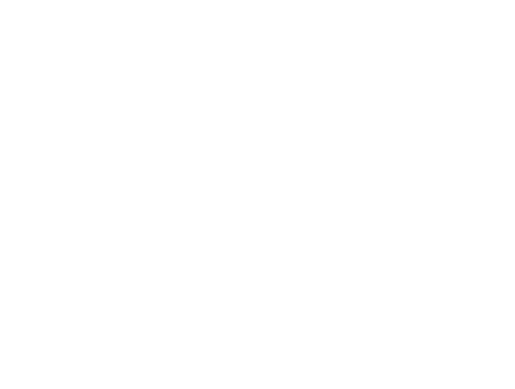

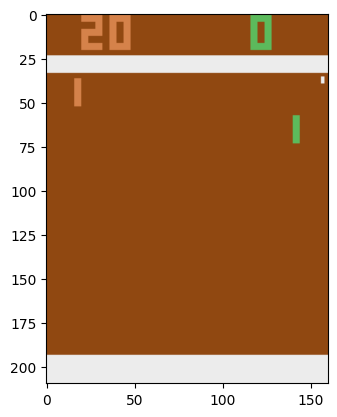

In [12]:
# after interact, open animation.mp4 see whole interact process
interact(env, policy, max_t=2000, nrand=5)

### 6. Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once


<div style="text-align: center;">
    <img src="./images/parallel-collect.png" alt="Mountain Car Environment" width="60%">
</div>

In [13]:
envs = ParallelEnv('PongDeterministic-v4', n=8, seed=42)

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [14]:
# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, max_t=200, nrand=5):

    # number of parallel instances
    n = len(envs.ps)

    # initialize returning lists and start the game!
    states = torch.zeros(max_t, n, 2, 80, 80, device=device)
    rewards = torch.zeros(max_t, n, device=device)
    probs = torch.zeros(max_t, n, device=device)
    actions = torch.zeros(max_t, n, dtype=torch.int8, device=device)

    # Initialize the game and perform random steps
    frame1, frame2 = perform_random_steps(envs, nrand, parallel=True)

    for t in range(max_t):

        # Predict actions
        state, action, actions_prob = policy.select_action((frame1, frame2), mode='collect')

        # Advance the game, we take one action and skip game forward
        frame1, reward1, done, _ = envs.step(action)
        frame2, reward2, done, _ = envs.step([Action.NOOP.value] * n)

        reward = reward1 + reward2

        # store the result
        states[t] = state
        rewards[t] = torch.from_numpy(reward)
        probs[t] = torch.from_numpy(actions_prob)
        actions[t] = torch.from_numpy(action)

        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if done.any():
            break
    
    # Convert time steps dimension into batch for vectorize inference
    states = states.view(-1, 2, 80, 80)
    
    return states, actions, probs, rewards


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [15]:
trajectories = collect_trajectories(envs, policy, max_t=100)
states, actions, probs, rewards = trajectories

### 7. Define Objective Function

**Future Rewards Matrix $R^{\rm future}$**

<div style="text-align: center;">
    <img src="./images/discounts.png" alt="Mountain Car Environment" width="60%">
</div>

**Policy Gradient**

$$
\nabla_\theta U(\theta) \approx \hat{g} = \frac{1}{B} \frac{1}{T} \sum_{i=1}^B \sum^T_t \nabla_\theta \log(\pi_{\theta'}(a_t|s_t)) R_{t} 
$$

**Policy Gradient with Future Rewards**

$$
\nabla_\theta U(\theta) \approx \hat{g} = \frac{1}{B} \frac{1}{T} \sum_{i=1}^B \sum^T_t \nabla_\theta \log(\pi_{\theta'}(a_t|s_t)) R_{t}^{\rm future}
$$

where $B$ is number of environments

**[Regularization Term in TRPO](https://arxiv.org/pdf/1502.05477)**

$$
H(\pi_{\theta'}, \pi_{\theta}) = - \frac{1}{B} \frac{1}{T} \sum_{i=1}^B \sum^T_t \pi_{\theta'}(a_t|s_t) \log\pi_{\theta}(a_t|s_t)
$$

where $\theta$ is previous policy and $\theta'$ is current policy

**Final Policy Gradient**

$$
\nabla_\theta U(\theta) \approx \hat{g} + \beta * H(\pi_{\theta'}, \pi_{\theta})
$$



In [16]:
def compute_future_rewards(rewards, gamma=0.99):
    """
    Compute future rewards using discount factors and matrix multiplication.
    
    Args:
        rewards: Tensor of rewards [T]
        gamma: Discount factor
        
    Returns:
        future_rewards: Tensor of future rewards [T]
    """
    T = len(rewards)
    indices = torch.arange(T).to(device=rewards.device)
    discounts_matrix = gamma ** (indices.unsqueeze(0) - indices.unsqueeze(1)).clamp_min(0)
    mask = torch.triu(torch.ones(T, T)).to(device=rewards.device)
    future_rewards = torch.matmul(discounts_matrix * mask, rewards)

    mean = future_rewards.mean(dim=1, keepdim=True)
    std = future_rewards.std(dim=1, keepdim=True)
    future_rewards = (future_rewards - mean) / (std + 1e-10)

    return future_rewards

print("Future rewards shape:", compute_future_rewards(rewards).shape)

Future rewards shape: torch.Size([100, 8])


In [18]:
def policy_gradient(policy, states, actions, old_probs, rewards, gamma=0.995, beta=0.01):
    
    # Compute and normalize future rewards
    future_rewards = compute_future_rewards(rewards, gamma=gamma)

    # Convert states to probability
    # probs shape: (time_steps, batch_size)
    probs = policy.get_action_probs(states, actions)

    # Compute policy gradient
    # (1/B)(1/T)∑∑R_t^future * log(π_θ(a_t|s_t))
    # g shape: (time_steps, batch_size)
    log_probs = torch.log(probs + 1.0e-10)
    g = (future_rewards * log_probs).mean()

    # Regularization term
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(
        probs * torch.log(old_probs + 1.0e-10)
        + (1.0 - probs) * torch.log(1.0 - old_probs + 1.0e-10)
    ).mean()

    return g + beta * entropy

pg = policy_gradient(policy, states, actions, probs, rewards)
pg

tensor(0.0072, device='mps:0', grad_fn=<AddBackward0>)

### 8. Training
We are now ready to train our policy!

**Multiple steps training**

The performance for the one shot training may be poor, so it is beneficial to train multiple epochs, first using a small max_t=200 with 500 episodes, and then train again with max_t = 400 with 500 episodes, and then finally with a even larger max_t=800 with 500 episodes. It may take up to 90 minutes with Apple M3 Max GPU for total three steps.

In [19]:
def improved_reinforce(
    envs,
    policy,
    optimizer,
    n_episodes=500,
    gamma=0.99,
    beta=0.01,
    max_t=320,
    window=20,
    checkpoint_path="checkpoint.pth"
):
    """
    Improved REINFORCE algorithm implementation with parallel environments
    
    Parameters:
    -----------
    envs : list or VectorEnv
        List of environments or vectorized environment
    policy : nn.Module
        Policy network
    optimizer : torch.optim.Optimizer
        Optimizer for policy network
    n_episodes : int
        Number of episodes to train
    gamma : float
        Discount factor
    beta : float
        Entropy coefficient for exploration
    max_t : int
        Maximum number of timesteps per episode
    window : int
        How often to print progress
    checkpoint_path : str
        Path to save the model checkpoint
        
    Returns:
    --------
    scores : list
        List of mean rewards per episode
    """
    n = len(envs.ps)

    # keep track of progress
    scores = []
    best_score = float('-inf')
    for i_episode in range(1, n_episodes + 1):
        # collect trajectories
        states, actions, probs, rewards = collect_trajectories(envs, policy, max_t=max_t)
        
        # calculate policy gradient
        pg = policy_gradient(policy, states, actions, probs, rewards, gamma=gamma, beta=beta)
        
        # perform optimization step
        loss = -pg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # reduce exploration over time
        beta *= 0.995
        
        # calculate total rewards
        total_rewards = rewards.sum(dim=0)
        
        # display progress
        avg_score = total_rewards.mean().item()
        
        # store mean reward on batch
        scores.append(avg_score)

        if avg_score > best_score:
            best_score = avg_score
            torch.save(policy.state_dict(), checkpoint_path)
            print(f"Checkpoint saved with new best score: {best_score:.2f}")
        
        if i_episode % window == 0:
            print(f"Episode {i_episode}\tAverage Score: {avg_score:.2f}")
            print(f"Total Rewards on {n} envs: {total_rewards.cpu().numpy()}")
    
    return scores

In [ ]:
# step1: using a small max_t=200 with 500 episodes
scores = improved_reinforce(
    envs=envs,
    policy=policy,
    optimizer=optimizer,
    n_episodes=500,
    gamma=0.99,
    beta=0.01,
    max_t=200,
	window=20
)

In [ ]:
# step2: using a small max_t=400 with 500 episodes
scores1 = improved_reinforce(
    envs=envs,
    policy=policy,
    optimizer=optimizer,
    n_episodes=500,
    gamma=0.99,
    beta=0.01,
    max_t=400,
	window=20
)

In [ ]:
# step3: using a small max_t=800 with 500 episodes
scores2 = improved_reinforce(
    envs=envs,
    policy=policy,
    optimizer=optimizer,
    n_episodes=500,
    gamma=0.99,
    beta=0.01,
    max_t=800,
	window=20
)

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
1495   -1.27500
1496   -1.27125
1497   -1.26625
1498   -1.27125
1499   -1.26625
Length: 1500, dtype: float64

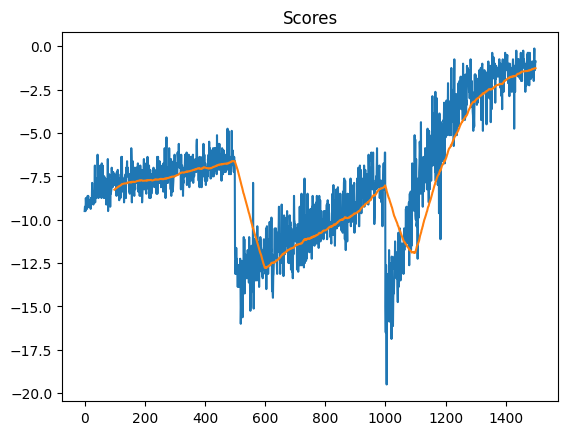

In [34]:
plot_scores(scores+scores1+scores2)

Animation saved to animation.mp4


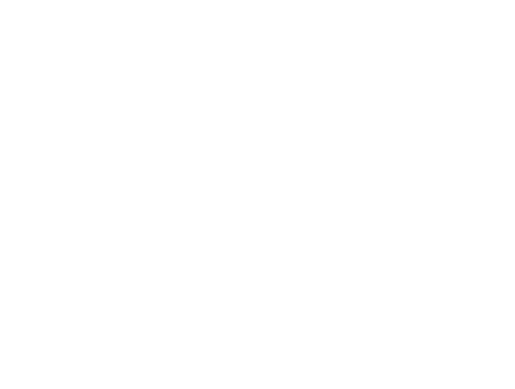

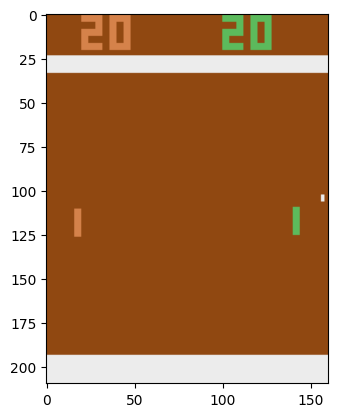

In [35]:
# play game after training!
policy.load_state_dict(torch.load('checkpoint.pth', weights_only=True))
interact(env, policy, max_t=2000)